## import packages, define variables

In [36]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import pandas as pd # for creation of data frames
import numpy as np #
import pyls # PLS: behavioral and mean-centered
import seaborn as sns
import nibabel as nib # for loading niftis etc. as arrays
import matplotlib.pyplot as plt # for plotting data
#the output of plotting commands is displayed inline, directly below the code cell that produced it
%matplotlib inline 
import os,glob
from nilearn import plotting, input_data, image #for plotting & working with niftis

import pathlib

###################### update path!! #####################################
base_path = '/root_dir/' ####
##########################################################################

#import qBOLD functions
#import sys
#sys.path.append(os.path.join(base_path + 'scripts/'))
#import mqBOLD_functions as qB


### define FSL directories ######################################################
os.environ["FSLDIR"]='/usr/share/fsl/5.0'
os.environ["FSLOUTPUTTYPE"]='NIFTI_GZ'
os.environ["FSLTCLSH"]='/usr/bin/tclsh'
os.environ["FSLWISH"]='/usr/bin/wish'
os.environ["FSLMULTIFILEQUIT"]="True"
os.environ["LD_LIBRARY_PATH"]='/usr/share/fsl/5.0:/usr/lib/fsl/5.0'
#################################################################################

In [37]:
data_dir = base_path + 'data/'
derivatives_dir = data_dir + 'derivatives'
raw_dir = data_dir + 'rawdata'
results_dir = base_path + 'results'
MNI_2mm_brain = derivatives_dir + '/MNI152_T1_2mm_brain.nii.gz'

sns.set_style("whitegrid")

coords=(-15, 0, 15, 30, 45, 60, 75, 90)


In [39]:
## Please specify task & baseline ##
####################################

baseline='control'
#baseline='rest'
task='calc'
#task='mem'

conds = [baseline, task]
contrast=task+baseline

## Automatically specify subject list##
################################

if baseline == 'control' and task == 'calc':
    #N=40
    sids = [19, 20, 21, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 46, 47, 48, 49, 50, 51, 52, 54, 55, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68]
else: #N=30, without p053
    sids = [19, 20, 21, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 46, 47, 48, 49, 50, 51, 52, 54, 55]

#N=11
#sids = [56, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68]

N_subj = str(len(sids))
GM_thresh = 0.5

## Gray-matter mask, excluding areas with low signal-to-noise ratio according to fMRI data

YEO_SNR_mask = os.path.join( derivatives_dir, 'task-all_space-MNI152_res-2_SNR_YEO_group_mask.nii.gz')

masker = input_data.NiftiMasker(mask_img=YEO_SNR_mask)
mask_img = masker.fit_transform(MNI_2mm_brain)


### BlueRed color palette

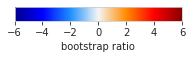

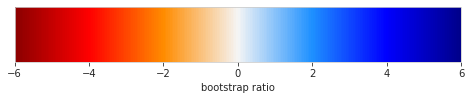

In [40]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

colors = ["darkblue", "blue", "dodgerblue",  "whitesmoke","darkorange", "red", "darkred"]
BlueRed = LinearSegmentedColormap.from_list("mycmap", colors)

fig, ax = plt.subplots(figsize=(3,0.5))
fig.subplots_adjust(bottom=0.5)

bounds = [-6, -4, -2, 0, 2, 4, 6]
norm = mpl.colors.Normalize(vmin=-6, vmax=6)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=BlueRed), 
             cax=ax, ticks=bounds, orientation='horizontal', label='bootstrap ratio')

## inverted colormap: BlueRed_r
colors = [ "darkred","red", "darkorange", "whitesmoke", "dodgerblue", "blue","darkblue"]
BlueRed_r = LinearSegmentedColormap.from_list("mycmap", colors)

fig, ax = plt.subplots(figsize=(8, 2))
fig.subplots_adjust(bottom=0.5)

bounds = [-6, -4, -2, 0, 2, 4, 6]
norm = mpl.colors.Normalize(vmin=-6, vmax=6)

fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=BlueRed_r), 
             cax=ax, ticks=bounds, orientation='horizontal', label='bootstrap ratio')

# mean-centered PLS on fMRI task data

## create input for PLS, func data, non-time resolved

In [ ]:
## load MNI and apply mask to get right shape for PLS input


PLS_input_localizer_median=np.empty([len(sids)*len(conds), mask_img.shape[1]]) 

for i, ID in enumerate(sids): #loop over subjects
    sub = "sub-p{:03d}".format(ID) 
    print(sub)

    
    dir_deriv = os.path.join(data_dir, 'derivatives', sub)
    dir_anat_deriv = os.path.join(data_dir, 'derivatives', sub, 'anat')
    dir_func_deriv = os.path.join(data_dir, 'derivatives', sub, 'func')
    dir_perf_deriv = os.path.join(data_dir, 'derivatives', sub, 'perf')
    dir_qmri_deriv = os.path.join(data_dir, 'derivatives', sub, 'qmri')
 

    ## normalized func data, output from fmriprep
    localizer_normalized = os.path.join(dir_func_deriv, sub +  'task-all_space-MNI152_res-2_desc-preproc_bold.nii.gz')
                                                                
    ## apply GM mask (with GM_thr defined)
    localizer_arr = masker.fit_transform(localizer_normalized)
    
    #############################################################
    ##create percent signal change values (baseline = median across time) ##
    #############################################################
 
    timeseries = [] #empty, to be sure to fill it with new values
    baseline_val = []  #empty, to be sure to fill it with new value

    timeseries = localizer_arr #shape: (400, 91406) or (200, 91406)
    if ID<56:
        #baseline: median of all conditions
        #baseline = np.median(timeseries)        
        # baseline = control                     
        if baseline == 'control':
            baseline_val = np.median(timeseries[list(range(80, 100)) + list(range(205, 225)) + list(range(280, 300)) + list(range(355, 375))])                                                     
        if baseline == 'rest':
            baseline_val= np.median(timeseries[list(range(5, 25)) + list(range(130, 150)) + list(range(230, 250)) + list(range(330, 350))])
        if baseline == 'mem':
            baseline_val= np.median(timeseries[list(range(30, 50)) + list(range(105, 125)) + list(range(180, 200)) + list(range(380, 400))])        
        
        percBOLD_4cond= 100 * (timeseries - baseline_val) / baseline_val
        
        if baseline == 'control':
            percBOLD_baseline = np.median((percBOLD_4cond[list(range(80, 100)) + list(range(205, 225)) + list(range(280, 300)) + list(range(355, 375))]),0)
        if baseline == 'rest':
            percBOLD_baseline = np.median((percBOLD_4cond[list(range(5, 25)) + list(range(130, 150)) + list(range(230, 250)) + list(range(330, 350))]),0)
        if baseline == 'mem':
            percBOLD_baseline = np.median((percBOLD_4cond[list(range(30, 50)) + list(range(105, 125)) + list(range(180, 200)) + list(range(380, 400))]), 0)
        if task == 'mem':
            percBOLD_task = np.median((percBOLD_4cond[list(range(30, 50)) + list(range(105, 125)) + list(range(180, 200)) + list(range(380, 400))]), 0)
        if task == 'calc':
            percBOLD_task = np.median((percBOLD_4cond[list(range(55, 75)) + list(range(155, 175)) + list(range(255, 275)) + list(range(305, 325))]), 0)
        if task == 'control':
            percBOLD_task = np.median((percBOLD_4cond[list(range(80, 100)) + list(range(205, 225)) + list(range(280, 300)) + list(range(355, 375))]),0)

    if ID>55: #only control and calc here
        #baseline: median of all conditions
        #baseline= np.median(timeseries)    
        # baseline = control 
        baseline_val = np.median(timeseries[list(range(5, 25)) + list(range(55, 75)) + list(range(105, 125)) + list(range(155, 175))])                     
        percBOLD_2cond = 100 * (timeseries - baseline_val) / baseline_val
        percBOLD_baseline=np.median((percBOLD_2cond[list(range(5, 25)) + list(range(55, 75)) + list(range(105, 125)) + list(range(155, 175))]),0)
        percBOLD_task = np.median((percBOLD_2cond[list(range(30, 50)) + list(range(80, 100)) + list(range(130, 150)) + list(range(180, 200))]),0)

        
    ## put into PLS data structure ##
    PLS_input_localizer_median[i] = percBOLD_baseline
    PLS_input_localizer_median[i + len(sids)] = percBOLD_task

##save data structure
np.save(os.path.join(results_dir,  'N' + N_subj +'_PLS_func_median_'+contrast+'_input.npy'), PLS_input_localizer_median)

### create input for mean-centered PLS, parameter maps

In [ ]:
MNI_arr = masker.fit_transform(MNI_2mm_brain)

#pre-define PLS input: all voxels for every subject per condition
PLS_input_CBF=np.empty([len(sids)*len(conds), MNI_arr.shape[1]])
PLS_input_CMRO2=np.empty([len(sids)*len(conds), MNI_arr.shape[1]])
PLS_input_OEF=np.empty([len(sids)*len(conds), MNI_arr.shape[1]])

for i, ID in enumerate(sids): #loop over subjects
    sub = "sub-p{:03d}".format(ID) 
    print(sub)
    
    dir_deriv = os.path.join(data_dir, 'derivatives', sub)
    dir_anat_deriv = os.path.join(data_dir, 'derivatives', sub, 'anat')
    dir_func_deriv = os.path.join(data_dir, 'derivatives', sub, 'func')
    dir_perf_deriv = os.path.join(data_dir, 'derivatives', sub, 'perf')
    dir_qmri_deriv = os.path.join(data_dir, 'derivatives', sub, 'qmri')
 
        
    T2_normalized =  os.path.join(dir_qmri_deriv, sub + '_space-MNI152_T2map.nii.gz')  ##coregistered to T2 TE1
        
    for k, cond in enumerate(conds):        
        
        ## CBF ##
        #########
        
        CBF_normalized = os.path.join(dir_qmri_deriv, sub + '_task-' + cond + '_space-MNI152_cbf.nii.gz')

        #plotting.plot_img(CBF_normalized, bg_img=MNI, display_mode='z', threshold = 10, cmap='viridis', black_bg=True, 
        #              cut_coords = (-20, 0,  20,  40, 60, 80, 100), vmin = 10, vmax = 70, title = subj_id)
        
        ## apply GM mask (with GM_thr defined)
        CBF_arr = masker.fit_transform(CBF_normalized)
        PLS_input_CBF[k*len(sids)+i,:]=CBF_arr;

        ## CMRO2 ##
        ###########

        if cond == 'calc': ## here we acquired 2 CBV, so these are the original data
            CMRO2_normalized = os.path.join(dir_qmri_deriv, sub + '_task-' + cond + '_space-MNI152_desc-CBV_cmro2.nii.gz')
        if cond != 'calc': ## here we acquired 2 CBV, so these are the original data
            CMRO2_normalized = os.path.join(dir_qmri_deriv, sub + '_task-' + cond + '_space-MNI152_desc-orig_cmro2.nii.gz')
            
        #plotting.plot_img(CMRO2_normalized, bg_img=MNI, display_mode='z', threshold = 10, cmap='viridis', black_bg=True, 
        #              cut_coords = (-20, 0,  20,  40, 60, 80, 100), vmin = 10, vmax = 70, title = subj_id)
        
        ## apply GM mask (with GM_thr defined)
        CMRO2_arr = masker.fit_transform(CMRO2_normalized)
        PLS_input_CMRO2[k*len(sids)+i,:]=CMRO2_arr;
        
        
        ## OEF ##
        ########### 
        OEF_normalized = os.path.join(dir_qmri_deriv, sub + '_task-' + cond + '_space-MNI152_oef.nii.gz')
                                        
        #plotting.plot_img(OEF_normalized, bg_img=MNI, display_mode='z', threshold = 10, cmap='viridis', black_bg=True, 
        #              cut_coords = (-20, 0,  20,  40, 60, 80, 100), vmin = 10, vmax = 70, title = subj_id)
        
        ## apply GM mask (with GM_thr defined)
        OEF_arr = masker.fit_transform(OEF_normalized)
        PLS_input_OEF[k*len(sids)+i,:]=OEF_arr;
        
        
np.save(results_dir + '/N' + N_subj +'_PLS_input_OEF_' + conds[1] + conds[0] + '.npy', PLS_input_OEF)
np.save(results_dir + '/N' + N_subj +'_PLS_input_CBF_' + conds[1] + conds[0] + '.npy', PLS_input_CBF)
np.save(results_dir + '/N' + N_subj +'_PLS_input_CMRO2_' + conds[1] + conds[0] + '.npy', PLS_input_CMRO2)

### Run PLS

In [ ]:
## functional data 

PLS_input_func_median= np.load(os.path.join(results_dir,  'N' + N_subj +'_PLS_func_median_'+contrast+'_input.npy'))

mpls_func_median = pyls.meancentered_pls(PLS_input_func_median, n_cond=len(conds), n_perm=3000, n_boot=3000)
np.save(os.path.join(results_dir,  'N' + N_subj +'_PLS_func_median_'+contrast+'.npy'), mpls_func_median)


In [ ]:
## CBF
PLS_input_CBF= np.load(os.path.join(results_dir, 'N' + N_subj +'_PLS_input_CBF_' + conds[1] + conds[0] + '.npy'))

mpls_CBF = pyls.meancentered_pls(PLS_input_CBF, n_cond=len(conds), n_perm=3000, n_boot=3000)
np.save(os.path.join(results_dir,  'N' + N_subj +'_PLS_cbf_median_'+contrast+'.npy'), mpls_CBF)

In [ ]:
##CMRO2

PLS_input_CMRO2= np.load(os.path.join(results_dir,  'N' + N_subj +'_PLS_input_CMRO2_' + conds[1] + conds[0] + '.npy'))

mpls_CMRO2 = pyls.meancentered_pls(PLS_input_CMRO2, n_cond=len(conds), n_perm=3000, n_boot=3000)
np.save(os.path.join(results_dir,  'N' + N_subj +'_PLS_cmro2_median_'+contrast+'.npy'), mpls_CMRO2)

# Results

In [ ]:
mpls_func = np.load(os.path.join(results_dir,  'N' + N_subj +'_PLS_func_median_'+contrast+'.npy'), allow_pickle='TRUE').item()

In [41]:
mpls_cbf = np.load(os.path.join(results_dir,  'N' + N_subj +'_PLS_cbf_median_'+contrast+'.npy'), allow_pickle='TRUE').item()
mpls_cmro2 = np.load(os.path.join(results_dir,  'N' + N_subj +'_PLS_cmro2_median_'+contrast+'.npy'), allow_pickle='TRUE').item()
#mpls_oef = np.load(os.path.join(results_dir,  'N' + N_subj +'_PLS_oef_median_'+contrast+'.npy'), allow_pickle='TRUE').item()


## p-values of latent variables

In [ ]:
print('p-values of func PLS: ' + str(mpls_func.permres.pvals))


In [42]:
print('p-values of CBF PLS: ' + str(mpls_cbf.permres.pvals))
print('p-values of CMRO2 PLS: ' + str(mpls_cmro2.permres.pvals))
#print('p-values of OEF PLS: ' + str(mpls_oef.permres.pvals))


p-values of CBF PLS: [3.33222259e-04 6.71109630e-01]
p-values of CMRO2 PLS: [0.00033322 0.24058647]


## brain scores & design scores of latent variables

In [ ]:
brain_scores_func= [mpls_func.x_scores[i, 0] for i in range(0,len(mpls_func.x_scores))]## first latent variables (significant)


In [43]:
brain_scores_cbf = [mpls_cbf.x_scores[i, 0] for i in range(0,len(mpls_cbf.x_scores))]## first latent variables (significant)
brain_scores_cmro2 = [mpls_cmro2.x_scores[i, 0] for i in range(0,len(mpls_cmro2.x_scores))]## first latent variables (significant)
#brain_scores_oef = [mpls_oef.x_scores[i, 0] for i in range(0,len(mpls_oef.x_scores))]## first latent variables (significant)

In [44]:
## show design scores

plt.rc('font', size=12) #controls default text size

design_scores_BOLD = [mpls_func.y_scores[i, 0] for i in range(0,len(mpls_func.y_scores))]## first latent variables (significant)

design_scores_df_BOLD = pd.DataFrame(columns = [1], index=conds) 
design_scores_df_BOLD.index.name = 'conditions'

design_scores_df_BOLD.loc[baseline] = design_scores_BOLD[len(sids)-1]
design_scores_df_BOLD.loc[task] = design_scores_BOLD[2*len(sids)-1]


IndexError: list index out of range

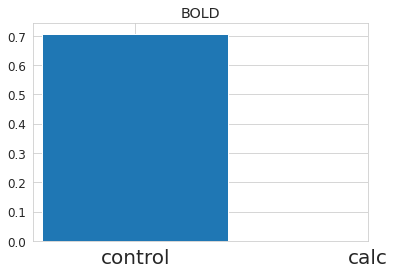

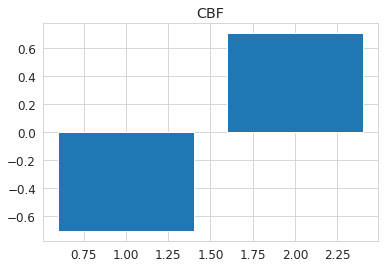

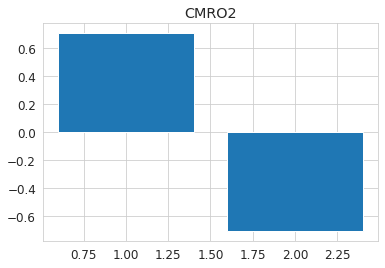

In [45]:
plt.rc('font', size=12) #controls default text size


design_scores_CBF = [mpls_cbf.y_scores[i, 0] for i in range(0,len(mpls_cbf.y_scores))]## first latent variables (significant)

design_scores_df_CBF = pd.DataFrame(columns = [1], index=conds) 
design_scores_df_CBF.index.name = 'conditions'


design_scores_df_CBF.loc[baseline] = design_scores_CBF[len(sids)-1]
design_scores_df_CBF.loc[task] = design_scores_CBF[2*len(sids)-1]
    
    ## plot ##
    
fig, ax = plt.subplots(1,1)
ax.bar([1, 2],[design_scores_df_BOLD.loc[baseline][1], design_scores_df_BOLD.loc[task][1]])
ax.set_xticks([1,2])
ax.set_xticklabels([baseline, task], fontsize=20)
ax.set_title('BOLD')
plt.show()

fig, ax = plt.subplots(1,1)
ax.bar([1, 2],[design_scores_df_CBF.loc[baseline][1], design_scores_df_CBF.loc[task][1]])
ax.set_title('CBF')
plt.show()


design_scores_CMRO2 = [mpls_cmro2.y_scores[i, 0] for i in range(0,len(mpls_cmro2.y_scores))]## first latent variables (significant)
design_scores_df_CMRO2 = pd.DataFrame(columns = [1], index=conds) 
design_scores_df_CMRO2.index.name = 'conditions'

#design_scores_OEF = [mpls_oef.y_scores[i, 0] for i in range(0,len(mpls_oef.y_scores))]## first latent variables (significant)
#design_scores_df_OEF = pd.DataFrame(columns = [1], index=conds) 
#design_scores_df_OEF.index.name = 'conditions'

    ## 2 conditions
design_scores_df_CMRO2.loc[baseline] = design_scores_CMRO2[len(sids)-1]
design_scores_df_CMRO2.loc[task] = design_scores_CMRO2[2*len(sids)-1]

#design_scores_df_OEF.loc[baseline] = design_scores_OEF[len(sids)-1]
#design_scores_df_OEF.loc[task] = design_scores_OEF[2*len(sids)-1]

    ## plot ##
    ###########

fig, ax = plt.subplots(1,1)
ax.bar([1, 2],[design_scores_df_CMRO2.loc[baseline][1], design_scores_df_CMRO2.loc[task][1]])
ax.set_title('CMRO2')
plt.show()

#fig, ax = plt.subplots(1,1)
#ax.bar([1, 2],[design_scores_df_OEF.loc[baseline][1], design_scores_df_OEF.loc[task][1]])
#ax.set_title('OEF')
#plt.show()

In [ ]:
bootstrap_results_1st_func = [mpls_func.bootres.x_weights_normed[i, 0] for i in range(0, len(mpls_func.bootres.x_weights_normed))] # for first latent variable

In [46]:
bootstrap_results_1st_CBF = [mpls_cbf.bootres.x_weights_normed[i, 0] for i in range(0, len(mpls_cbf.bootres.x_weights_normed))] # for first latent variable
bootstrap_results_1st_CMRO2 = [mpls_cmro2.bootres.x_weights_normed[i, 0] for i in range(0, len(mpls_cmro2.bootres.x_weights_normed))] # for first latent variable
#bootstrap_results_1st_OEF = [mpls_oef.bootres.x_weights_normed[i, 0] for i in range(0, len(mpls_oef.bootres.x_weights_normed))] # for first latent variable


## mask BSR results

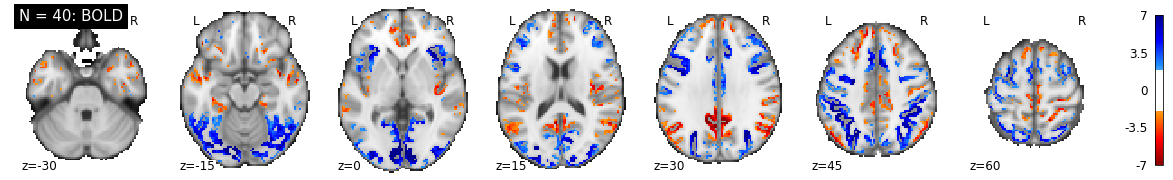

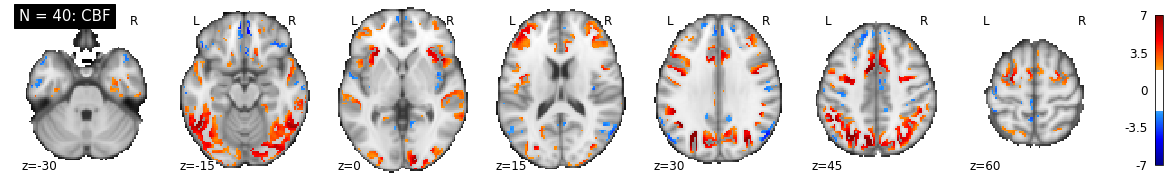

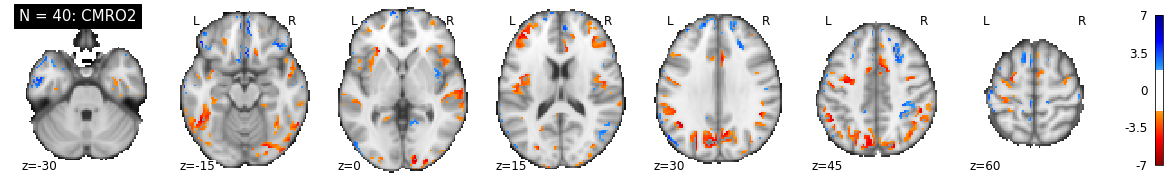

In [47]:
## create BSR images for all modalities, masked 
BSR_thr = 2
#coords=(-30, -20, -10, 0, 10, 20, 30, 40, 50, 60, 70)
coords = (-30, -15, 0, 15, 30, 45, 60)
colors = BlueRed
colors_r = BlueRed_r
maxval = 7
minval = -7

YEO17_2mm = os.path.join(derivatives_dir,'Yeo2011_17Networks_MNI152_FreeSurferConformed2mm_LiberalMask_MNI.nii.gz')

##BOLD
BSR_masked_func = masker.inverse_transform(bootstrap_results_1st_func)
nib.save(BSR_masked_func, os.path.join(results_dir, 'N' + N_subj +'_BSR_meanPLS_func_' + contrast + '.nii.gz'))
BSR_masked_func=   os.path.join(results_dir, 'N' + N_subj +'_BSR_meanPLS_func_' + contrast + '.nii.gz')
BSR_masked_BOLD_YEO =  os.path.join(results_dir, 'N' + N_subj +'_BSR_meanPLS_func_' + contrast + '_YEOmask.nii.gz')


## mask with YEO regions to kick out cerebellum etc
! fslmaths {BSR_masked_func} -mas {YEO17_2mm} {BSR_masked_BOLD_YEO}
    

##CBF
BSR_masked_CBF = masker.inverse_transform(bootstrap_results_1st_CBF)
nib.save(BSR_masked_CBF, os.path.join(results_dir, 'N' + N_subj +'_BSR_meanPLS_cbf_' + contrast + '.nii.gz'))
BSR_masked_CBF=  os.path.join(results_dir, 'N' + N_subj +'_BSR_meanPLS_cbf_' + contrast + '.nii.gz')
BSR_masked_CBF_YEO =  os.path.join(results_dir, 'N' + N_subj +'_BSR_meanPLS_cbf_' + contrast + '_YEOmask.nii.gz')

## mask with YEO regions to kick out cerebellum etc
! fslmaths {BSR_masked_CBF} -mas {YEO17_2mm} {BSR_masked_CBF_YEO}


##CMRO2
BSR_masked_CMRO2 = masker.inverse_transform(bootstrap_results_1st_CMRO2)
nib.save(BSR_masked_CMRO2,  os.path.join(results_dir, 'N' + N_subj +'_BSR_meanPLS_cmro2_' + contrast + '.nii.gz'))
BSR_masked_CMRO2=  os.path.join(results_dir, 'N' + N_subj +'_BSR_meanPLS_cmro2_' + contrast + '.nii.gz')
BSR_masked_CMRO2_YEO =   os.path.join(results_dir, 'N' + N_subj +'_BSR_meanPLS_cmro2_' + contrast + '_YEOmask.nii.gz')

## mask with YEO regions to kick out cerebellum etc
! fslmaths {BSR_masked_CMRO2} -mas {YEO17_2mm} {BSR_masked_CMRO2_YEO}

##OEF
#BSR_masked_OEF = masker.inverse_transform(bootstrap_results_1st_OEF)
#nib.save(BSR_masked_OEF, os.path.join(results_dir, 'N' + N_subj +'_BSR_meanPLS_oef_' + contrast + '.nii.gz'))
#BSR_masked_OEF= os.path.join(results_dir, 'N' + N_subj +'_BSR_meanPLS_oef_' + contrast + '.nii.gz')
#BSR_masked_OEF_YEO =  os.path.join(results_dir, 'N' + N_subj +'_BSR_meanPLS_oef_' + contrast + '_YEOmask.nii.gz')

## mask with YEO regions to kick out cerebellum etc
#! fslmaths {BSR_masked_OEF} -mas {YEO17_2mm} {BSR_masked_OEF_YEO}


##BOLD
if design_scores_df_BOLD.loc[task][1] > 0: #higher in calc
        my_color = colors
else:
        my_color = colors_r
plot=plotting.plot_img(BSR_masked_BOLD_YEO, bg_img=MNI_2mm_brain, display_mode='z', threshold=BSR_thr, cmap=my_color, colorbar = True, black_bg=False,
                    cut_coords = coords, title='N = ' + N_subj + ': BOLD', vmin = minval, vmax = maxval)


##CBF
if design_scores_df_CBF.loc[task][1] > 0:
        my_color = colors
else:
        my_color =colors_r
plot=plotting.plot_img(BSR_masked_CBF_YEO, bg_img=MNI_2mm_brain, display_mode='z', threshold=BSR_thr, cmap=my_color, colorbar = True, black_bg=False,
                    cut_coords = coords, title='N = ' + N_subj + ': CBF', vmin = minval, vmax = maxval)


    ##OEF
#if design_scores_df_OEF.loc[task][1] > 0:
#        my_color = colors
#else:
#        my_color = colors_r
#plot=plotting.plot_img(BSR_masked_OEF_YEO, bg_img=MNI_2mm_brain, display_mode='z', threshold=BSR_thr, cmap=my_color, colorbar = True, black_bg=False,
#                    cut_coords = coords, title='N = ' + N_subj + ': OEF', vmin = minval, vmax =maxval)

    ##CMRO2
if design_scores_df_CMRO2.loc[task][1] > 0:
        my_color = colors
else:
        my_color = colors_r
plot=plotting.plot_img(BSR_masked_CMRO2_YEO, bg_img=MNI_2mm_brain, display_mode='z', threshold=BSR_thr, cmap=my_color, colorbar = True, black_bg=False,
                    cut_coords = coords, title='N = ' + N_subj + ': CMRO2', vmin = minval, vmax = maxval)


## cluster-threshold and binarize BSR maps

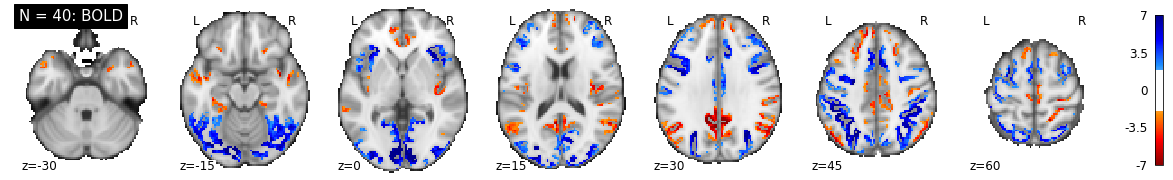

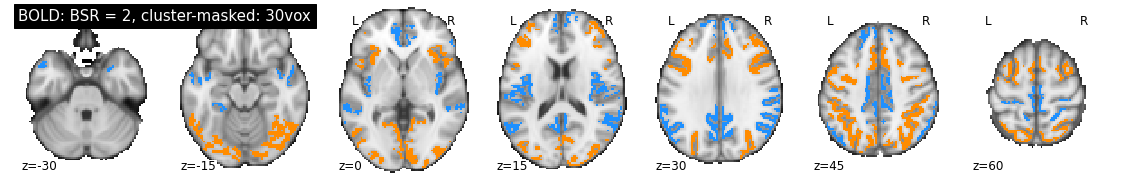

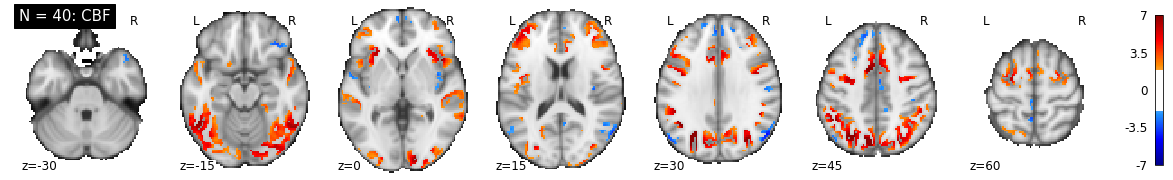

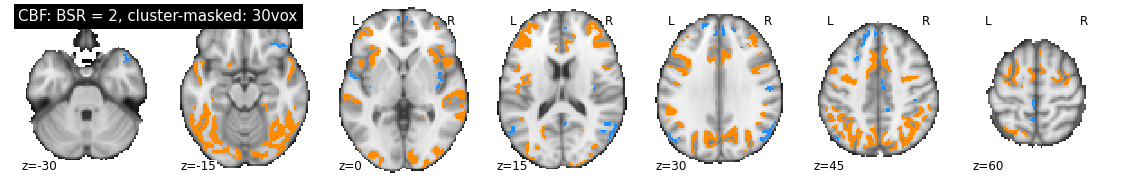

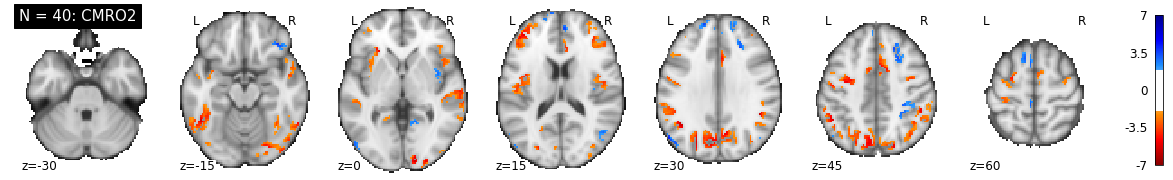

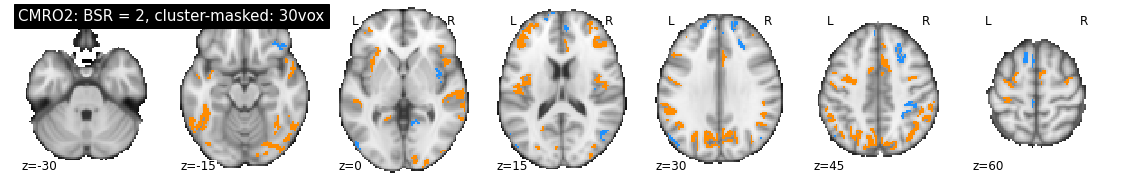

In [48]:
## apply cluster threshold
from nilearn import glm
from matplotlib.colors import ListedColormap

cl_threshold = 30

## create binary colormap
newcmp_pos = ListedColormap(["darkorange"])
newcmp_neg = ListedColormap(["dodgerblue"])


    ############
    ## BOLD ##
    ###########
BSR_cluster_thr = glm.threshold_stats_img(BSR_masked_BOLD_YEO, mask_img=None, alpha=0.05, threshold=BSR_thr, height_control=None, cluster_threshold=cl_threshold, two_sided=True)
nib.save(BSR_cluster_thr[0],results_dir + '/N' + N_subj +'_BSR_meanPLS_func_clusterBSR'+contrast+'.nii.gz')
BSR_cluster_thr_nii = results_dir + '/N' + N_subj +'_BSR_meanPLS_func_clusterBSR'+contrast+'.nii.gz'
##BOLD
if design_scores_df_BOLD.loc[task][1] > 0: #higher in calc
        my_color = colors
else:
        my_color = colors_r
plot=plotting.plot_img(BSR_cluster_thr_nii, bg_img=MNI_2mm_brain, display_mode='z', threshold=BSR_thr, cmap=my_color, colorbar = True, black_bg=False,
                    cut_coords = coords, title='N = ' + N_subj + ': BOLD', vmin = minval, vmax = maxval)
    
## separate into positive and negative clusters
if design_scores_df_BOLD.loc[task][1] > 0: #if task = orange
        ! fslmaths {BSR_cluster_thr_nii} -thr {BSR_thr} {BSR_cluster_thr_nii}_pos
        ! fslmaths {BSR_cluster_thr_nii} -uthr {-BSR_thr} {BSR_cluster_thr_nii}_neg
if design_scores_df_BOLD.loc[task][1] < 0: #if task = orange
        ! fslmaths {BSR_cluster_thr_nii} -thr {BSR_thr} {BSR_cluster_thr_nii}_neg
        ! fslmaths {BSR_cluster_thr_nii} -uthr {-BSR_thr} {BSR_cluster_thr_nii}_pos     
 
## binarize and save
neg_nii = results_dir + '/N' + N_subj +'_BSR_meanPLS_func_clusterBSR'+contrast+'.nii.gz_neg.nii.gz'
pos_nii = results_dir + '/N' + N_subj +'_BSR_meanPLS_func_clusterBSR'+contrast+'.nii.gz_pos.nii.gz'
neg_nii_bin = results_dir + '/N' + N_subj +'_BSR_meanPLS_func_clusterBSR'+contrast+'_neg_bin.nii.gz'
pos_nii_bin = results_dir + '/N' + N_subj +'_BSR_meanPLS_func_clusterBSR'+contrast+'_pos_bin.nii.gz'
! fslmaths {neg_nii} -abs -bin {neg_nii_bin}
! fslmaths {pos_nii} -abs -bin {pos_nii_bin}


##plot binarized
display = plotting.plot_img(BSR_cluster_thr_nii + '_pos.nii.gz', bg_img=MNI_2mm_brain, threshold = 0, display_mode='z', cmap=newcmp_pos, 
                    cut_coords = coords, title='BOLD: BSR = ' + str(BSR_thr) + ', cluster-masked: 30vox')
display.add_overlay(BSR_cluster_thr_nii + '_neg.nii.gz',cmap=newcmp_neg)

    ############
    ## CBF ##
    #############
BSR_cluster_thr = glm.threshold_stats_img(BSR_masked_CBF_YEO, mask_img=None, alpha=0.05, threshold=BSR_thr, height_control=None, cluster_threshold=cl_threshold, two_sided=True)
nib.save(BSR_cluster_thr[0],results_dir + '/N' + N_subj +'_BSR_meanPLS_cbf_clusterBSR'+contrast+'.nii.gz')
BSR_cluster_thr_nii = results_dir + '/N' + N_subj +'_BSR_meanPLS_cbf_clusterBSR'+contrast+'.nii.gz'

##CBF
if design_scores_df_CBF.loc[task][1] > 0:
        my_color = colors
else:
        my_color =colors_r
plot=plotting.plot_img(BSR_cluster_thr_nii, bg_img=MNI_2mm_brain, display_mode='z', threshold=BSR_thr, cmap=my_color, colorbar = True, black_bg=False,
                    cut_coords = coords, title='N = ' + N_subj + ': CBF', vmin = minval, vmax = maxval)

## plot cluster-corrected image: blue - orange
if design_scores_df_CBF.loc[task][1] > 0: #if task = orange
        ! fslmaths {BSR_cluster_thr_nii} -thr {BSR_thr} {BSR_cluster_thr_nii}_pos
        ! fslmaths {BSR_cluster_thr_nii} -uthr {-BSR_thr} {BSR_cluster_thr_nii}_neg
if design_scores_df_CBF.loc[task][1] < 0: #if task = orange
        ! fslmaths {BSR_cluster_thr_nii} -thr {BSR_thr} {BSR_cluster_thr_nii}_neg
        ! fslmaths {BSR_cluster_thr_nii} -uthr {-BSR_thr} {BSR_cluster_thr_nii}_pos 

## binarize and save
neg_nii = results_dir + '/N' + N_subj +'_BSR_meanPLS_cbf_clusterBSR'+contrast+'.nii.gz_neg.nii.gz'
pos_nii = results_dir + '/N' + N_subj +'_BSR_meanPLS_cbf_clusterBSR'+contrast+'.nii.gz_pos.nii.gz'
neg_nii_bin = results_dir + '/N' + N_subj +'_BSR_meanPLS_cbf_clusterBSR'+contrast+'_neg_bin.nii.gz'
pos_nii_bin = results_dir + '/N' + N_subj +'_BSR_meanPLS_cbf_clusterBSR'+contrast+'_pos_bin.nii.gz'
! fslmaths {neg_nii} -abs -bin {neg_nii_bin}
! fslmaths {pos_nii} -abs -bin {pos_nii_bin}

##plot binarized
display = plotting.plot_img(BSR_cluster_thr_nii + '_pos.nii.gz', bg_img=MNI_2mm_brain, threshold = 0, display_mode='z', cmap=newcmp_pos, 
                    cut_coords = coords, title='CBF: BSR = ' + str(BSR_thr) + ', cluster-masked: 30vox')
display.add_overlay(BSR_cluster_thr_nii + '_neg.nii.gz',cmap=newcmp_neg)

    ############
    ## CMRO2 ##
    #############
    ## CMRO2 CALC is CBV-corrected

BSR_cluster_thr = glm.threshold_stats_img(BSR_masked_CMRO2_YEO, mask_img=None, alpha=0.05, threshold=BSR_thr, height_control=None, cluster_threshold=cl_threshold, two_sided=True)
nib.save(BSR_cluster_thr[0],results_dir + '/N' + N_subj +'_BSR_meanPLS_cmro2_clusterBSR'+contrast+'.nii.gz')
BSR_cluster_thr_nii = results_dir + '/N' + N_subj +'_BSR_meanPLS_cmro2_clusterBSR'+contrast+'.nii.gz'
    
    ##CMRO2
if design_scores_df_CMRO2.loc[task][1] > 0:
        my_color = colors
else:
        my_color = colors_r
plot=plotting.plot_img(BSR_cluster_thr_nii, bg_img=MNI_2mm_brain, display_mode='z', threshold=BSR_thr, cmap=my_color, colorbar = True, black_bg=False,
                    cut_coords = coords, title='N = ' + N_subj + ': CMRO2', vmin = minval, vmax = maxval)

    ## plot cluster-corrected image: blue - orange
if design_scores_df_CMRO2.loc[task][1] > 0: #if task = orange
        ! fslmaths {BSR_cluster_thr_nii} -thr {BSR_thr} {BSR_cluster_thr_nii}_pos
        ! fslmaths {BSR_cluster_thr_nii} -uthr {-BSR_thr} {BSR_cluster_thr_nii}_neg
if design_scores_df_CMRO2.loc[task][1] < 0: #if task = orange
        ! fslmaths {BSR_cluster_thr_nii} -thr {BSR_thr} {BSR_cluster_thr_nii}_neg
        ! fslmaths {BSR_cluster_thr_nii} -uthr {-BSR_thr} {BSR_cluster_thr_nii}_pos 


## binarize and save
neg_nii = results_dir + '/N' + N_subj +'_BSR_meanPLS_cmro2_clusterBSR'+contrast+'.nii.gz_neg.nii.gz'
pos_nii = results_dir + '/N' + N_subj +'_BSR_meanPLS_cmro2_clusterBSR'+contrast+'.nii.gz_pos.nii.gz'
neg_nii_bin = results_dir + '/N' + N_subj +'_BSR_meanPLS_cmro2_clusterBSR'+contrast+'_neg_bin.nii.gz'
pos_nii_bin = results_dir + '/N' + N_subj +'_BSR_meanPLS_cmro2_clusterBSR'+contrast+'_pos_bin.nii.gz'
! fslmaths {neg_nii} -abs -bin {neg_nii_bin}
! fslmaths {pos_nii} -abs -bin {pos_nii_bin}


##plot binarized
display = plotting.plot_img(BSR_cluster_thr_nii + '_pos.nii.gz', bg_img=MNI_2mm_brain, threshold = 0, display_mode='z', cmap=newcmp_pos, 
                    cut_coords = coords, title='CMRO2: BSR = ' + str(BSR_thr) + ', cluster-masked: 30vox')
display.add_overlay(BSR_cluster_thr_nii + '_neg.nii.gz',cmap=newcmp_neg)
